
#  Feature Inspection & Leakage Checks

**Project:** Sea Surface Temperature Anomaly Forecasting (SSTA)  





## Learning goals
- Load the feature matrix and profile shapes, types, and missingness.
- Verify **no leakage** in lag/rolling features (past-only alignment).
- Inspect **correlation** with the target anomaly and among features.
- Visualize selected features over time to validate behavior.
- Produce a lightweight **data dictionary** for documentation.



## Setup & configuration
.


In [16]:

# --- Configuration ---
PROJECT = "ssta_plymouth"         
PROCESSED_DIR = "../data/processed"

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore

def detect_features_path(processed_dir: str, project: str) -> Path:
    candidates = [
        Path(processed_dir) / f"features_{project}.parquet",
        Path(processed_dir) / f"features_{project}.csv",
        
        Path(processed_dir) / f"features_ssta_{project}.parquet",
        Path(processed_dir) / f"features_ssta_{project}.csv",
    ]
    for p in candidates:
        if p.exists():
            return p
    matches = sorted(list(Path(processed_dir).glob("features_*.parquet")) +
                     list(Path(processed_dir).glob("features_*.csv")))
    if not matches:
        raise FileNotFoundError(f"No features file found in {processed_dir}. Looked for: {candidates}")
    return matches[-1]



## 1. Load features
Expected schema: `date` (monthly timestamp), `ssta` (target), and engineered features.


In [17]:
fpath = detect_features_path(PROCESSED_DIR, PROJECT)
print(f"Using features file: {fpath}")

if fpath.suffix.lower() == ".parquet":
    feats = pd.read_parquet(fpath)
else:
    feats = pd.read_csv(fpath)

# Normalize
feats = feats.rename(columns={c: c.lower() for c in feats.columns})
feats["date"] = pd.to_datetime(feats["date"], errors="coerce")
feats = feats.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
feats["date"] = feats["date"].dt.to_period("M").dt.to_timestamp()

# Basic profile
display_cols = ["date"] + [c for c in feats.columns if c != "date"][:10]
print("Shape:", feats.shape)
print("Head:")
print(feats[display_cols].head())
print("Dtypes:")
print(feats.dtypes)


Using features file: ../data/processed/features_ssta_plymouth.parquet
Shape: (506, 20)
Head:
        date      ssta  ssta_lag1  ssta_lag2  ssta_lag3  ssta_lag4  ssta_lag5  \
0 1983-07-01  0.895277  -1.006746  -1.271505  -1.297522  -1.081948  -1.526412   
1 1983-08-01  0.446053   0.895277  -1.006746  -1.271505  -1.297522  -1.081948   
2 1983-09-01 -1.006529   0.446053   0.895277  -1.006746  -1.271505  -1.297522   
3 1983-10-01 -0.729173  -1.006529   0.446053   0.895277  -1.006746  -1.271505   
4 1983-11-01 -0.497573  -0.729173  -1.006529   0.446053   0.895277  -1.006746   

   ssta_lag6  ssta_lag12  ssta_lag18  ssta_rollmean3  
0  -0.381204   -0.290744   -1.337977       -1.191924  
1  -1.526412   -0.619217   -0.859627       -0.460992  
2  -1.081948   -0.006029   -0.504851        0.111528  
3  -1.297522   -0.998984   -0.248244        0.111600  
4  -1.271505   -0.624656   -0.275887       -0.429883  
Dtypes:
date               datetime64[ns]
ssta                      float32
ssta_lag1     


## 2. Missingness & coverage
We summarize missing values and time coverage.


In [18]:

na_counts = feats.isna().sum().sort_values(ascending=False)
print("Missing values per column (top 20):")
print(na_counts.head(20))

print("\nTime coverage:")
print(feats["date"].min(), "→", feats["date"].max(), "   (rows:", len(feats), ")")


Missing values per column (top 20):
date               0
ssta               0
cos_3              0
sin_3              0
cos_2              0
sin_2              0
cos_1              0
sin_1              0
ssta_rollmean12    0
ssta_rollmean6     0
ssta_rollmean3     0
ssta_lag18         0
ssta_lag12         0
ssta_lag6          0
ssta_lag5          0
ssta_lag4          0
ssta_lag3          0
ssta_lag2          0
ssta_lag1          0
t                  0
dtype: int64

Time coverage:
1983-07-01 00:00:00 → 2025-08-01 00:00:00    (rows: 506 )



## 3. Group features by type
We categorize columns by naming patterns for quick inspection.


In [19]:

def group_columns(df: pd.DataFrame) -> dict:
    groups = {"target":["ssta"], "lags":[], "rolling":[], "fourier":[], "trend":[], "indices":[], "other":[]}
    for c in df.columns:
        if c == "date":
            continue
        lc = c.lower()
        if lc == "ssta":
            continue
        if "lag" in lc:
            groups["lags"].append(c)
        elif "rollmean" in lc or "rolling" in lc:
            groups["rolling"].append(c)
        elif lc.startswith("sin_") or lc.startswith("cos_"):
            groups["fourier"].append(c)
        elif lc == "t" or lc.endswith("_trend"):
            groups["trend"].append(c)
        elif lc in {"oni","mei","mei_v2","pdo","amo","dmi"} or any(k in lc for k in ["oni","mei","pdo","amo","dmi"]):
            groups["indices"].append(c)
        else:
            groups["other"].append(c)
    return groups

groups = group_columns(feats)
for k,v in groups.items():
    print(f"{k}: {len(v)} columns")
    if v:
        print("  e.g.,", v[:8])


target: 1 columns
  e.g., ['ssta']
lags: 8 columns
  e.g., ['ssta_lag1', 'ssta_lag2', 'ssta_lag3', 'ssta_lag4', 'ssta_lag5', 'ssta_lag6', 'ssta_lag12', 'ssta_lag18']
rolling: 3 columns
  e.g., ['ssta_rollmean3', 'ssta_rollmean6', 'ssta_rollmean12']
fourier: 6 columns
  e.g., ['sin_1', 'cos_1', 'sin_2', 'cos_2', 'sin_3', 'cos_3']
trend: 1 columns
  e.g., ['t']
indices: 0 columns
other: 0 columns



## 4. Leakage checks
We verify that rolling means are past-only (shifted by 1) and that lags behave as expected.


In [20]:

checks = []

# Rolling windows: recompute expected past-only rolling and compare
for c in groups["rolling"]:
    try:
        # window size from column name, e.g., ssta_rollmean12 -> 12
        w = int("".join([ch for ch in c if ch.isdigit()])) if any(ch.isdigit() for ch in c) else None
        if w and "ssta" in c:
            exp = feats["ssta"].shift(1).rolling(w, min_periods=w).mean()
            diff = (feats[c] - exp).abs().dropna()
            max_abs = float(diff.max()) if not diff.empty else 0.0
            ok = (max_abs < 1e-6) or diff.isna().all()
            checks.append((c, "rolling_past_only", ok, max_abs))
    except Exception as e:
        checks.append((c, "rolling_past_only", False, str(e)))

# Lag columns: a quick alignment check using correlation with appropriately shifted target
for c in groups["lags"]:
    try:
        # extract lag number
        nums = "".join([ch for ch in c if ch.isdigit()])
        L = int(nums) if nums else None
        if L is not None and "ssta" in c:
            corr_same = feats[["ssta", c]].dropna().corr().iloc[0,1]
            # expected stronger correlation with target shifted forward by L
            tgt_shift = feats["ssta"].shift(-L)
            corr_shifted = pd.concat([tgt_shift, feats[c]], axis=1).dropna().corr().iloc[0,1]
            checks.append((c, "lag_alignment_corr", float(corr_shifted) >= float(corr_same), (float(corr_same), float(corr_shifted))))
    except Exception as e:
        checks.append((c, "lag_alignment_corr", False, str(e)))

ck = pd.DataFrame(checks, columns=["feature","check","passed","detail"])
print(ck)


            feature               check  passed  \
0    ssta_rollmean3   rolling_past_only    True   
1    ssta_rollmean6   rolling_past_only    True   
2   ssta_rollmean12   rolling_past_only    True   
3         ssta_lag1  lag_alignment_corr   False   
4         ssta_lag2  lag_alignment_corr   False   
5         ssta_lag3  lag_alignment_corr   False   
6         ssta_lag4  lag_alignment_corr    True   
7         ssta_lag5  lag_alignment_corr   False   
8         ssta_lag6  lag_alignment_corr   False   
9        ssta_lag12  lag_alignment_corr   False   
10       ssta_lag18  lag_alignment_corr   False   

                                        detail  
0                                          0.0  
1                                          0.0  
2                                          0.0  
3     (0.7372383161886048, 0.5615843105375428)  
4     (0.5540720677317252, 0.4208808053169876)  
5    (0.4543956718367208, 0.45242621172991654)  
6     (0.411144736215848, 0.4225939222121185


## 5. Correlation with target
Compute Pearson correlations between each feature and `ssta` (same timestamp).  
Interpretation: Larger magnitude suggests stronger linear association.


In [21]:

corrs = []
for c in feats.columns:
    if c in ("date","ssta"):
        continue
    s = pd.concat([feats["ssta"], feats[c]], axis=1).dropna()
    if len(s) > 10:
        corrs.append((c, float(s.corr().iloc[0,1])))
corr_df = pd.DataFrame(corrs, columns=["feature","corr_with_ssta"]).sort_values("corr_with_ssta", key=lambda s: s.abs(), ascending=False)
print(corr_df.head(20))


            feature  corr_with_ssta
0         ssta_lag1        0.737238
8    ssta_rollmean3        0.657205
9    ssta_rollmean6        0.633956
10  ssta_rollmean12        0.610390
1         ssta_lag2        0.554072
17                t        0.551505
2         ssta_lag3        0.454396
5         ssta_lag6        0.447454
4         ssta_lag5        0.434115
3         ssta_lag4        0.411145
6        ssta_lag12        0.328852
7        ssta_lag18        0.328029
14            cos_2        0.019775
12            cos_1       -0.019304
13            sin_2        0.018556
11            sin_1        0.017067
16            cos_3       -0.005339
15            sin_3        0.001749



## 6. Feature–feature collinearity (correlation heatmap)
We draw a small heatmap (absolute correlations) for the top-N features by target correlation.


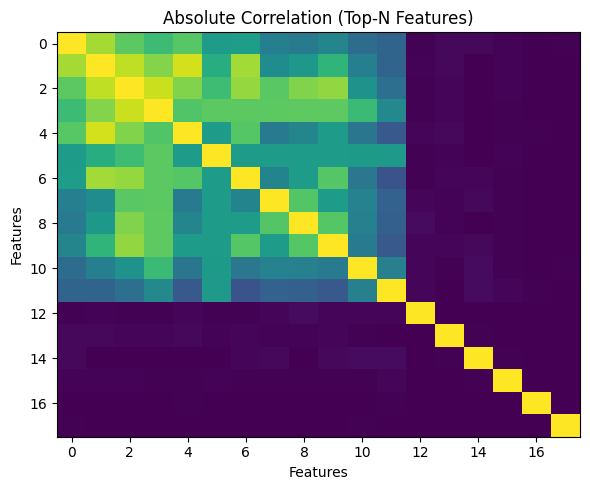

In [11]:

TOP_N = 20
top_feats = corr_df["feature"].head(TOP_N).tolist()
sub = feats[top_feats].dropna()
if len(sub) > 2:
    C = sub.corr().abs().values
    plt.figure(figsize=(6,5))
    plt.imshow(C, aspect='auto')
    plt.title("Absolute Correlation (Top-N Features)")
    plt.xlabel("Features"); plt.ylabel("Features")
    plt.tight_layout(); plt.show()
else:
    print("Not enough complete rows to plot correlation heatmap.")



## 7. Time series spot-checks
Plot a few representative features over time to validate behavior (lags, rolling, indices).


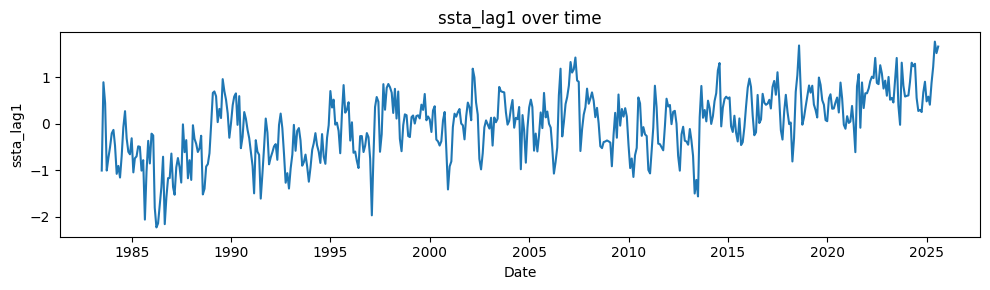

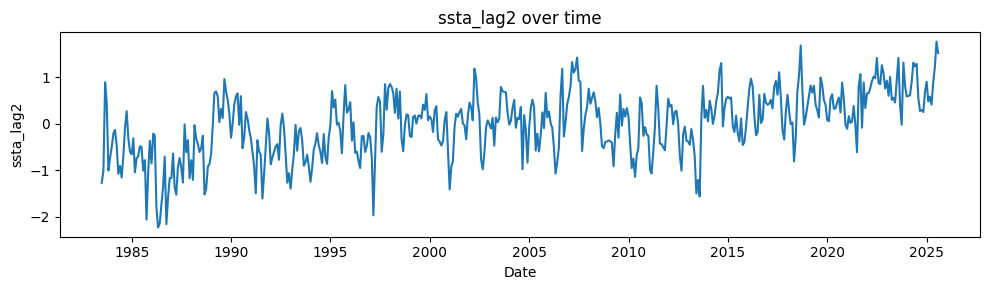

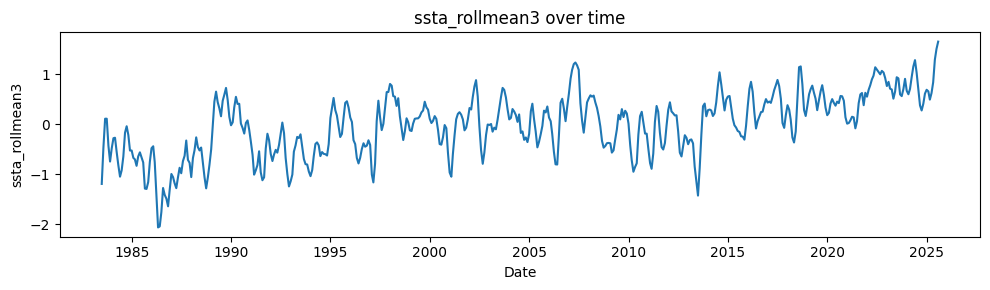

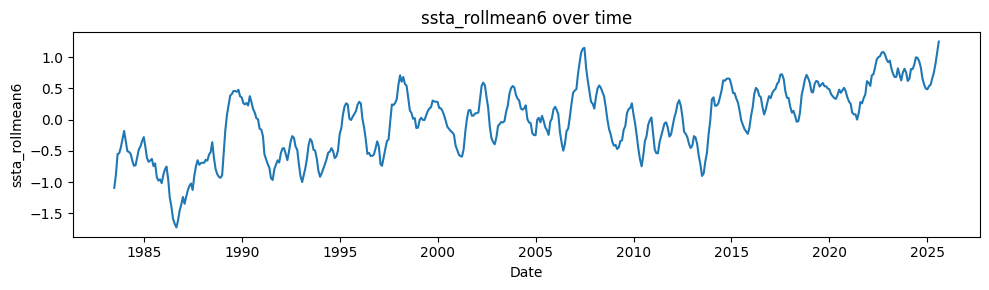

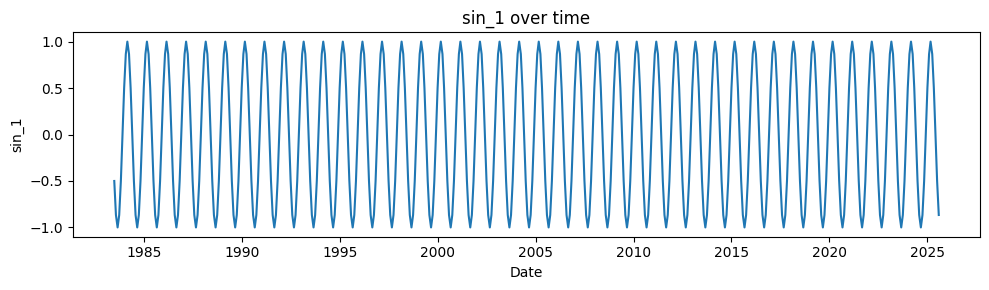

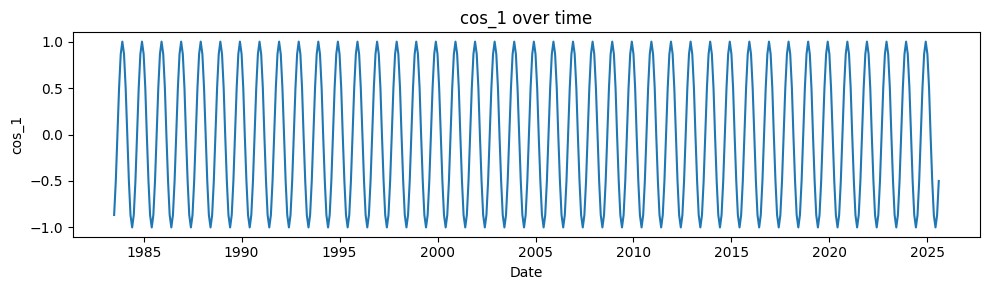

In [12]:

def plot_feature_ts(name: str, n_points: int = None):
    if name not in feats.columns:
        print(f"{name} not found.")
        return
    ser = feats[["date", name]].dropna()
    if n_points:
        ser = ser.tail(n_points)
    plt.figure(figsize=(10,3))
    plt.plot(ser["date"], ser[name])
    plt.title(f"{name} over time")
    plt.xlabel("Date"); plt.ylabel(name)
    plt.tight_layout(); plt.show()

# Examples: tweak as you like
examples = []
examples += groups["lags"][:2]
examples += groups["rolling"][:2]
examples += groups["fourier"][:2]
examples += groups["indices"][:2]

for ex in examples:
    plot_feature_ts(ex, n_points=None)



## 8. Lightweight linear model sanity check 
We fit a regularized linear model  as a quick signal check.


In [14]:

try:
    from sklearn.linear_model import RidgeCV
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    ok_sklearn = True
except Exception as e:
    print("scikit-learn not available; skipping quick model check.")
    ok_sklearn = False

if ok_sklearn:
    dfm = feats.dropna().copy()
    y = dfm["ssta"].astype(float).to_numpy()
    X = dfm.drop(columns=["date","ssta"]).to_numpy()
    tscv = TimeSeriesSplit(n_splits=5)
    maes, rmses = [], []
    for tr, te in tscv.split(X):
        model = RidgeCV(alphas=(0.1, 1.0, 10.0))
        model.fit(X[tr], y[tr])
        yhat = model.predict(X[te])
        maes.append(mean_absolute_error(y[te], yhat))
        rmses.append(mean_squared_error(y[te], yhat) ** 0.5)
    print("RidgeCV MAE (mean ± std):", np.mean(maes), "±", np.std(maes))
    print("RidgeCV RMSE (mean ± std):", np.mean(rmses), "±", np.std(rmses))


RidgeCV MAE (mean ± std): 0.3562268683025126 ± 0.02834694536478559
RidgeCV RMSE (mean ± std): 0.4490700725493732 ± 0.03649896829662233



## 9. Data dictionary 
A compact, human-readable description of columns by group.


In [15]:

rows = []
for g, cols in groups.items():
    if not cols: 
        continue
    for c in cols:
        rows.append({
            "group": g,
            "column": c,
            "notes": ("Lagged feature" if g=="lags" else
                      "Rolling mean (past-only)" if g=="rolling" else
                      "Fourier seasonal term" if g=="fourier" else
                      "Simple time trend" if g=="trend" else
                      "External climate index (or lag)" if g=="indices" else "")
        })
dd = pd.DataFrame(rows).sort_values(["group","column"]).reset_index(drop=True)
print(dd.head(30))
dd_path = Path(PROCESSED_DIR) / f"data_dictionary_{PROJECT}.csv"
dd.to_csv(dd_path, index=False)
print(f"Saved data dictionary → {dd_path}")


      group           column                     notes
0   fourier            cos_1     Fourier seasonal term
1   fourier            cos_2     Fourier seasonal term
2   fourier            cos_3     Fourier seasonal term
3   fourier            sin_1     Fourier seasonal term
4   fourier            sin_2     Fourier seasonal term
5   fourier            sin_3     Fourier seasonal term
6      lags        ssta_lag1            Lagged feature
7      lags       ssta_lag12            Lagged feature
8      lags       ssta_lag18            Lagged feature
9      lags        ssta_lag2            Lagged feature
10     lags        ssta_lag3            Lagged feature
11     lags        ssta_lag4            Lagged feature
12     lags        ssta_lag5            Lagged feature
13     lags        ssta_lag6            Lagged feature
14  rolling  ssta_rollmean12  Rolling mean (past-only)
15  rolling   ssta_rollmean3  Rolling mean (past-only)
16  rolling   ssta_rollmean6  Rolling mean (past-only)
17   targe